<a href="https://colab.research.google.com/github/paruliansaragi/cnn-fastai/blob/master/FastaiLesson8and9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Detection

"Stacks of differentiable non-linear functions with lots of parameters can sole almost any predictive modelling problem"

## Transfer Learning

Replace Last Layer => Fine-tune new layers => Fine-tune more layers (optional)

You never want to start with random weights unless noone has a model that has worked with data anywhere near that domain which is very unlikely. 


- Given a network that does thing A, remove the last layer.

- Replace it with a few random layers at the end

- Fine-tune those layers to do thing B while taking advantage of the features that the original 
network learned

- Then optionally fine tune the whole thing end-to-end and you now have something which probably uses orders of magnitude less data, is more accurate, and trains a lot faster.

Build a model that overfits. Then use these techniques to reduce overfit: add more data, data aug, batch norm, regularisation such as weight decay and dropout.



**Object Detection**

1. we have multiple things we want to classify

2. Bounding boxes around what we are classifying

Our job will be to take data that has been labeled in this way and on data that is unlabeled to generate classes of the objects and each one of those their bounding boxes. One thing to note is that labeling this kind of data is generally more expensive [37:09]. For object detection datasets, **annotators** are given a **list of object classes and asked to find every single one of them of any type in a picture along with where they are.** In this case why isn’t there a tree or jump labeled? That is because for this particular dataset, they were not one of the classes that annotators were asked to find and therefore not part of this particular problem.

### Stages

1. Classify the largest object in each image.

2. Find the location of the largest object in each image.

3. Finally try and do both at the same time. 

In [0]:
#https://pjreddie.com/projects/pascal-voc-dataset-mirror/
!wget http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
!wget http://pjreddie.com/media/files/VOCtest_06-Nov-2007.tar

--2018-10-14 11:20:02--  http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
Resolving pjreddie.com (pjreddie.com)... 128.208.3.39
Connecting to pjreddie.com (pjreddie.com)|128.208.3.39|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar [following]
--2018-10-14 11:20:02--  https://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
Connecting to pjreddie.com (pjreddie.com)|128.208.3.39|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/octet-stream]
Saving to: ‘VOCtrainval_06-Nov-2007.tar’

VOCtrainval_06-Nov- 100%[===================>] 438.72M   109MB/s    in 4.1s    

2018-10-14 11:20:06 (108 MB/s) - ‘VOCtrainval_06-Nov-2007.tar’ saved [460032000/460032000]

URL transformed to HTTPS due to an HSTS policy
--2018-10-14 11:20:07--  https://pjreddie.com/media/files/VOCtest_06-Nov-2007.tar
Resolving pjreddie.com (pjreddie.com)...

In [0]:
!tar xzfv VOCtrainval_06-Nov-2007.tar
!tar xzfv VOCtest_06-Nov-2007.tar


gzip: stdin: not in gzip format
tar: Child returned status 1
tar: Error is not recoverable: exiting now

gzip: stdin: not in gzip format
tar: Child returned status 1
tar: Error is not recoverable: exiting now


In [0]:
!tar xvf VOCtest_06-Nov-2007.tar

In [0]:
!tar xvf VOCtrainval_06-Nov-2007.tar

In [0]:
!wget https://storage.googleapis.com/coco-dataset/external/PASCAL_VOC.zip

--2018-10-14 11:47:11--  https://storage.googleapis.com/coco-dataset/external/PASCAL_VOC.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.128, 2607:f8b0:400e:c09::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1998182 (1.9M) [application/zip]
Saving to: ‘PASCAL_VOC.zip’

PASCAL_VOC.zip      100%[===================>]   1.91M  --.-KB/s    in 0.02s   

2018-10-14 11:47:12 (90.2 MB/s) - ‘PASCAL_VOC.zip’ saved [1998182/1998182]



In [0]:
!unzip PASCAL_VOC.zip

Archive:  PASCAL_VOC.zip
   creating: PASCAL_VOC/
  inflating: PASCAL_VOC/pascal_test2007.json  
  inflating: PASCAL_VOC/pascal_train2007.json  
  inflating: PASCAL_VOC/pascal_train2012.json  
  inflating: PASCAL_VOC/pascal_val2007.json  
  inflating: PASCAL_VOC/pascal_val2012.json  


In [0]:
!mkdir data/pascal

In [0]:
!mv data/pascal/PASCAL_VOC data
!mv data/VOCdevkit data/PASCAL_VOC

mv: cannot stat 'data/pascal/PASCAL_VOC': No such file or directory


In [0]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from fastai.conv_learner import *
from fastai.dataset import *
from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
# torch.cuda.set_device(1)  

In [0]:
PATH = Path('data/PASCAL_VOC')
list(PATH.iterdir())

[PosixPath('data/PASCAL_VOC/pascal_val2007.json'),
 PosixPath('data/PASCAL_VOC/pascal_train2007.json'),
 PosixPath('data/PASCAL_VOC/pascal_val2012.json'),
 PosixPath('data/PASCAL_VOC/VOCdevkit'),
 PosixPath('data/PASCAL_VOC/pascal_test2007.json'),
 PosixPath('data/PASCAL_VOC/tmp'),
 PosixPath('data/PASCAL_VOC/models'),
 PosixPath('data/PASCAL_VOC/pascal_train2012.json')]

The Pascal VOC is the imagenet equivalent for object detection. 
We will be using the Pathlib python standard library for our paths and file access. 

http://pbpython.com/pathlib-intro.html



Python Generator:

A generator is something in Python 3 that you can iterate over.

- for i in path iterdir(): print i 
- [i for i in PATH.iterdir()] list comprehension
- list(PATH.iterdir()) (turns a generator into a list)

The reasons things return generators is that if the directory had 10 million items in, you don't necessarily want 10 million long list. Generators let you do things lazily.



In [0]:
#As well as images, there are annotations - bounding boxes showing where each object is. These are hand labelled. The original
#were done in xml but we now are using the json version
#Pathlib gives you the ability to open files amongst many others.
trn_j = json.load((PATH/'pascal_train2007.json').open())
#PATH gets you children in that path. The above returns a pathlib object which has an open method. This json contains the bb's and classes.
trn_j.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [0]:
IMAGES,ANNOTATIONS,CATEGORIES = ['images', 'annotations', 'categories']
trn_j[IMAGES][:5]

[{'file_name': '000012.jpg', 'height': 333, 'id': 12, 'width': 500},
 {'file_name': '000017.jpg', 'height': 364, 'id': 17, 'width': 480},
 {'file_name': '000023.jpg', 'height': 500, 'id': 23, 'width': 334},
 {'file_name': '000026.jpg', 'height': 333, 'id': 26, 'width': 500},
 {'file_name': '000032.jpg', 'height': 281, 'id': 32, 'width': 500}]

Annotations

- bbox : column, row (of top left), height, width
- image_id : you’d have join this up with trn_j[IMAGES] (above) to find file_name etc.
- category_id : see trn_j[CATEGORIES] (below)
- segmentation : polygon segmentation (we will be using them)
- ignore : we will ignore the ignore flags
- iscrowd : specifies that it is a crowd of that object, not just one of them

In [0]:
trn_j[ANNOTATIONS][:2]

[{'area': 34104,
  'bbox': [155, 96, 196, 174],
  'category_id': 7,
  'id': 1,
  'ignore': 0,
  'image_id': 12,
  'iscrowd': 0,
  'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]]},
 {'area': 13110,
  'bbox': [184, 61, 95, 138],
  'category_id': 15,
  'id': 2,
  'ignore': 0,
  'image_id': 17,
  'iscrowd': 0,
  'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]]}]

In [0]:
trn_j[CATEGORIES][:4]

[{'id': 1, 'name': 'aeroplane', 'supercategory': 'none'},
 {'id': 2, 'name': 'bicycle', 'supercategory': 'none'},
 {'id': 3, 'name': 'bird', 'supercategory': 'none'},
 {'id': 4, 'name': 'boat', 'supercategory': 'none'}]

In [0]:
FILE_NAME,ID,IMG_ID,CAT_ID,BBOX = 'file_name','id','image_id','category_id','bbox'

cats = {o[ID]:o['name'] for o in trn_j[CATEGORIES]}
trn_fns = {o[ID]:o[FILE_NAME] for o in trn_j[IMAGES]}
trn_ids = [o[ID] for o in trn_j[IMAGES]]

#Most of deep learning is it not working - tenacity separates those who are effective!

In [0]:
#lets take a look at the images

list((PATH/'VOCdevkit'/'VOC2007').iterdir())


[PosixPath('data/PASCAL_VOC/VOCdevkit/VOC2007/ImageSets'),
 PosixPath('data/PASCAL_VOC/VOCdevkit/VOC2007/SegmentationObject'),
 PosixPath('data/PASCAL_VOC/VOCdevkit/VOC2007/JPEGImages'),
 PosixPath('data/PASCAL_VOC/VOCdevkit/VOC2007/Annotations'),
 PosixPath('data/PASCAL_VOC/VOCdevkit/VOC2007/SegmentationClass')]

In [0]:
#Creating a dictionary 
#key: image id, value: annotations
JPEGS = 'VOCdevkit/VOC2007/JPEGImages'
IMG_PATH = PATH/JPEGS
list(IMG_PATH.iterdir())[:5]

[PosixPath('data/PASCAL_VOC/VOCdevkit/VOC2007/JPEGImages/009611.jpg'),
 PosixPath('data/PASCAL_VOC/VOCdevkit/VOC2007/JPEGImages/004470.jpg'),
 PosixPath('data/PASCAL_VOC/VOCdevkit/VOC2007/JPEGImages/006656.jpg'),
 PosixPath('data/PASCAL_VOC/VOCdevkit/VOC2007/JPEGImages/001699.jpg'),
 PosixPath('data/PASCAL_VOC/VOCdevkit/VOC2007/JPEGImages/008784.jpg')]

In [0]:
#Each image has a unique id
im0_d = trn_j[IMAGES][0]
im0_d[FILE_NAME], im0_d[ID]

('000012.jpg', 12)

In [0]:
#a defaultdict is useful anytime you want to have a default dictionary entry for new keys.
#Here we create a dict from image IDs to a list of annotations (tuple of bb's and class id)
#We convert VOC's height/width to top-left/bottom-right and convert x/y to be numpy compatible
def hw_bb(bb): return np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])

trn_anno = collections.defaultdict(lambda:[])
#if a key doesn't exist it makes one and sets the return value equal to the function we passed
for o in trn_j[ANNOTATIONS]:
    if not o['ignore']:
        bb = o[BBOX]
        bb = hw_bb(bb)
        trn_anno[o[IMG_ID]].append((bb,o[CAT_ID]))
        
len(trn_anno)

2501

In [0]:
im_a = trn_anno[im0_d[ID]]; im_a
#example 1
# When we created the bb we did a few things;
# we swapped the x and y coordinates 
#The reason being is that in comp vision when you say my screen is 640 by 480 that is width by height
#The pillow lib tends to do things width by heigh or col by rows, and numpy is the opposite way around
#The second is, that we are going to describe things by top-left xy and bottom-right xy coordiante instead of x,y,height,width

[(array([ 96, 155, 269, 350]), 7)]

In [0]:
im0_a = im_a[0]; im0_a

(array([ 96, 155, 269, 350]), 7)

In [0]:
#7: class label/category 
cats[7]

'car'

In [0]:
trn_anno[17]

[(array([ 61, 184, 198, 278]), 15), (array([ 77,  89, 335, 402]), 13)]

In [0]:
cats[15], cats[13]

('person', 'horse')

In [0]:
#some libraries take VOC format bb's, so this let's us convert back when needed

bb_voc = [155, 96, 196, 174]
bb_fastai = hw_bb(bb_voc)

def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])
f'expected: {bb_voc}, actual: {bb_hw(bb_fastai)}'


'expected: [155, 96, 196, 174], actual: [155  96 196 174]'

In [0]:
#we use fastai's image function
#takes a path as input and opens an image using OpenCV and returns np float representation normalised between 0-1 in rgb format
im = open_image(IMG_PATH/im0_d[FILE_NAME])

In [0]:
??open_image
##Lets talk about open_image
#Fastai uses opencv since it was faster than torchVision and PIL
#Python has a thing called the global interpreter lock (GIL), which means two threads can do pythonic things at the same time.
#which makes python bad but OpenCV releases GIL. Fastai is fast because it uses multi threading instead of multiple processors for data aug.
#Unfortunately OpenCV has an inscrutable API and documentations are somewhat obtuse. 
#That is why Jeremy tried to make it so that no one using fast.ai needs to know that it’s using OpenCV. 
#You don’t need to know what flags to pass to open an image. 
#You don’t need to know that if the reading fails, it doesn’t show an exception — it silently returns None.
#~~STICK TO OPENCV for Processing~~#

In [0]:
#Using Matplotlib better
#Trick 1 plt.subplots
#plt.subplots is a really good wrapper for creating plots regardless of whether you have one or more plots.

def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax
  #it returns two things a figure object and an axes object.
  #Anywhere where you say plt. something you now say ax. something
  #it will now do the plotting to that particular subplot. 
  #This is helpful when you want to plot multiple plots so you can compare next to each other.

  #Trick 2 
  #a simple but rarely used trick is to set text visible regardless of background
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])
  

In [0]:
# * is a splat operator https://stackoverflow.com/questions/5239856/foggy-on-asterisk-in-python
# In this case it's a little shortcut compared to writing out b[-2],b[-1].
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

In [0]:
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

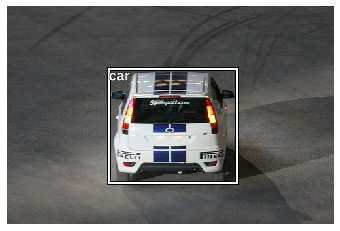

In [0]:
ax = show_img(im)
b = bb_hw(im0_a[0])
draw_rect(ax, b)
draw_text(ax, b[:2], cats[im0_a[1]])

In [0]:
#Packaging it all up
def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)
    

In [0]:
def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(IMG_PATH/trn_fns[i])
    print(im.shape)
    draw_im(im, im_a)

(364, 480, 3)


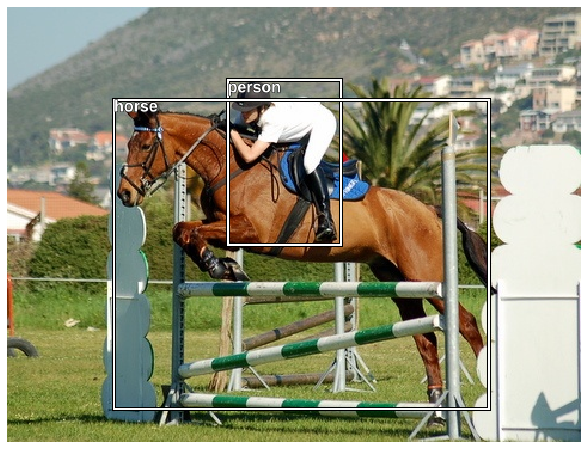

In [0]:
draw_idx(17)

In [0]:
#Largest Item classifier
#First thing we need to do is go through each of the bb's in an image and find the biggest one
#a lambda function is simply a way to define an anonymous function inline
#here we use it to describe how to sort the annotations for each image by bb size in descending order
# We subtract the upper left from bottom right and multiply (np.product) the values to get an area
# lambda x: np.product(x[0][-2:]-x[0][:2])
def get_lrg(b):
    if not b: raise Exception()
    b = sorted(b, key=lambda x: np.product(x[0][-2:]-x[0][:2]), reverse=True)
    return b[0]


In [0]:
#dict comprehension
trn_lrg_anno = {a: get_lrg(b) for a,b in trn_anno.items()}
#now we have a dictionary from image id to a single bb - the largest for that image

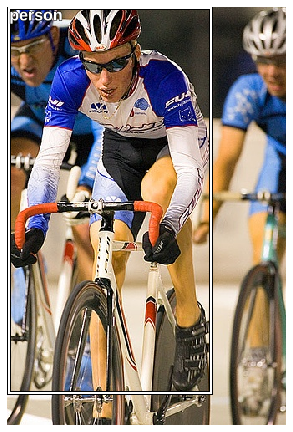

In [0]:
b,c = trn_lrg_anno[23]
b = bb_hw(b)
ax = show_img(open_image(IMG_PATH/trn_fns[23]), figsize=(5,10))
draw_rect(ax, b)
draw_text(ax, b[:2], cats[c], sz=16)

In [0]:
(PATH/'tmp').mkdir(exist_ok=True)
CSV = PATH/'tmp/lrg.csv'
#its easier to create a csv of the data you want to model than create a custom dataset
#here we use pandas to help us create a csv of image filename and class. colums=['fn','cat']
#is there because dictionary doesnt have an order and order of things matter

df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids],
    'cat': [cats[trn_lrg_anno[o][1]] for o in trn_ids]}, columns=['fn','cat'])
df.to_csv(CSV, index=False)

In [0]:
f_model = resnet34
sz=224
bs=64

In [0]:
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, crop_type=CropType.NO)
#one diff thing is crop_type
#the default strategy for creating a 224 by 224 is to resize so that the smallest size is 224
#then take a random squared crop during training
#during validation we take a centre crop unless we use data aug
#in obj det we dont want to do that so we set CropType.NO
md = ImageClassifierData.from_csv(PATH, JPEGS, CSV, tfms=tfms, bs=bs)

In [0]:
#the main thing to know about a dataloader is that:
#it is an iterator that every time you grab the next iteration, you get a mini-batch
#the mini-batch you get is of whatever size you asked for and by default the batch size is 64
#In python the way you grab the next thing from an iterator is with next(md.trn_dl) but you cant just do that!
#because you need to tell python to start from the beginning of a sequence.
#The way you do that is iter(md.trn_dl) which will grab an iterator our of md.trn_dl
#it means the class has to have a defined __iter__ method which returns some different object
#which then has the __next__ method.

#If you want to grab a single batch you do this, (x: independent variable, y: dependent variable):
x,y=next(iter(md.val_dl))
#we cannot send this straight away to show_image. x is not an numpy array, not on cpu, and the shape is all wrong (3x224x224)
#Further more they are not numbers between 0 and 1 because all of the standard imagenet pretrained models expect our data
#to have been normalised to have a zero mean and 1 standard deviation

![alt text](https://cdn-images-1.medium.com/max/1200/1*CbjuSpn8ZnX6SMLNiBzoag.png)

In [0]:
#As you can see, there is a whole bunch of things that has been done to the input to get it ready to be passed to a pre-trained model.
#We have a function denorm that normalises and also fixes the dimension order
#since denormalization depends on the transform and dataset (val_ds) knows what transform was used to create it,
#so that is why you have to do md.val_ds.denorm and pass the minibatch after turning it into a numpy array (to_np)

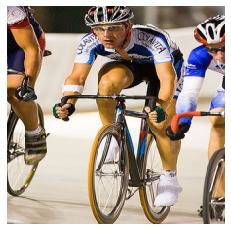

In [0]:
show_img(md.val_ds.denorm(to_np(x))[0]);

In [0]:
#Training with resnet34
learn = ConvLearner.pretrained(f_model, md, metrics=[accuracy])
learn.opt_fn = optim.Adam

In [0]:
lrf=learn.lr_find(1e-5,100)


 78%|███████▊  | 25/32 [00:19<00:02,  2.57it/s, loss=10.1]

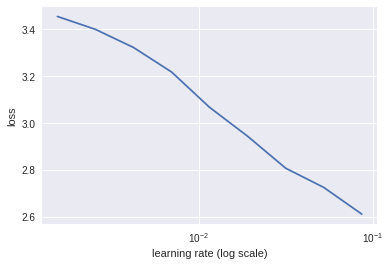

In [0]:
learn.sched.plot()


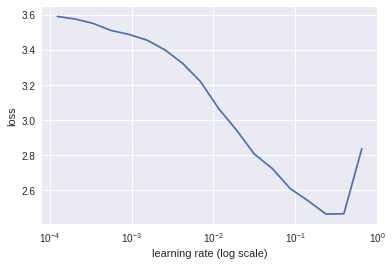

In [0]:
# We intentionally remove the first few and last few points
#because often the last few points shoot up to infinity that you cant see anything 
#which have very few mini-batches, it is not a good idea. 
#When your LR finder graph looks like above, you can ask for more points on each end (you can also make your batch size really small):
learn.sched.plot(n_skip=5, n_skip_end=1)


In [0]:
lr = 2e-2
learn.fit(lr, 1, cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      1.251381   0.655127   0.784     


[array([0.65513]), 0.7840000023841858]

In [0]:
#Unfreeze a couple of layers
lrs = np.array([lr/1000,lr/100,lr])
learn.freeze_to(-2)


 84%|████████▍ | 27/32 [00:24<00:02,  1.83it/s, loss=4.04]

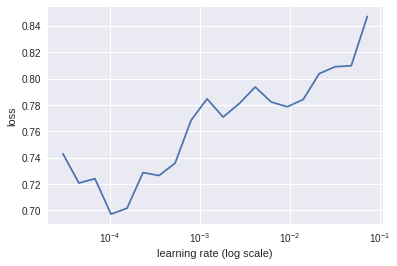

In [0]:
lrf=learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [0]:
learn.fit(lrs/5, 1, cycle_len=1)


epoch      trn_loss   val_loss   accuracy   
    0      0.760162   0.598194   0.818     


[array([0.59819]), 0.8179999990463257]

In [0]:
#Unfreeze the whole thing
learn.unfreeze()
learn.fit(lrs/5, 1, cycle_len=2)
#Accuracy isn't improving much
#- since many images have multiple different objects, it's going to be impossible to be that accurate.

epoch      trn_loss   val_loss   accuracy   
    0      0.638711   0.581793   0.83      
    1      0.452576   0.564746   0.832     


[array([0.56475]), 0.8319999976158142]

In [0]:
learn.save('clas_one')
learn.load('clas_one')

In [0]:
#let's look at the results
x,y = next(iter(md.val_dl))
probs = F.softmax(predict_batch(learn.model, x), -1)
x,preds = to_np(x),to_np(probs)
preds = np.argmax(preds, -1)

In [0]:
#How to understand unfamiliar code
# - Run each code step by step and print the inputs and outputs

# - Method 1 -
# You can take the contents of the loop, copy it, create a cell above it, 
# paste it, un-indent it, set i=0 and put them all in separate cells.

![alt text](https://cdn-images-1.medium.com/max/1200/1*mOfiv9blUSSx5iFEArlZNw.png)

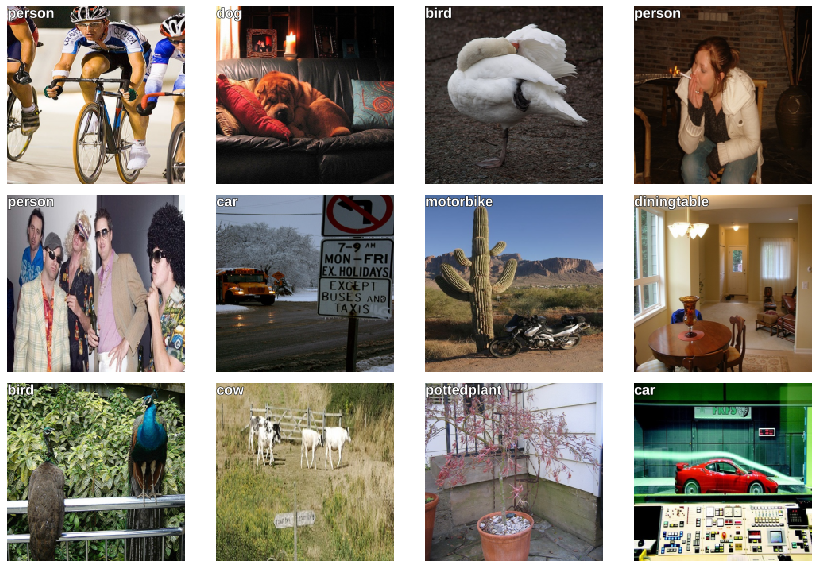

In [0]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(x)[i]
    b = md.classes[preds[i]]
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0,0), b)
plt.tight_layout()

In [0]:
# - Method 2 -
# Use the python debugger to step through code
# - pdb.set_trace() to set a breakpoint
# %debug magic to trace an error 
#Commands you need to know:

#h (help)
#s (step into)
#n (next line / step over — you can also hit enter)
#c (continue to the next breakpoint)
#u (up the call stack)
#d (down the call stack)
#p (print) — force print when there is a single letter variable that’s also a command.
#l (list) — show the line above and below it
#q (quit) — very important

#Ipython core debugger makes it prettier

![alt text](https://cdn-images-1.medium.com/max/900/1*4WryeZDtKFciD7qchVA6WQ.png)
![alt text](https://cdn-images-1.medium.com/max/900/1*aztHN3af_MxEhHS71_SUDQ.png)

In [0]:
#Creating the bounding box

#Classification neural net is the one that has a sigmoid or softmax output, 
#and we use a cross entropy, binary cross entropy, or negative log likelihood loss function. 
#That is basically what makes it classifier. If we don’t have the softmax or sigmoid at 
#the end and we use mean squared error as a loss function, it is now a regression model 
#which predict continuous number rather than a category. We also know that we can have multiple outputs like 
#in the planet competition (multiple classification). 

# ~~ What if we combine the two ideas and do a multiple column regression? ~~

In [0]:
#This is why its differentiable programming, it is not how do you creating a bb model but more like:

# - We need four number thus we need a NN that returns four activations
# - For loss function, what is a function that when it is lowered the four numbers are better? Mean squared loss function!


In [0]:
trn_ids

In [0]:
# BBOX only ~

# Now we'll try to find the bounding box of the largest object. 
# This is simply a regression with 4 outputs. So we can use a CSV with multiple 'labels'.
# To do multiple label classification, your multiple labels have to be space separated and the file name is comma separated
BB_CSV = PATH/'tmp/bb.csv'

bb = np.array([trn_lrg_anno[o][0] for o in trn_ids])
bbs = [' '.join(str(p) for p in o) for o in bb]

df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'bbox': bbs}, columns=['fn','bbox'])
df.to_csv(BB_CSV, index=False)


In [0]:
BB_CSV.open().readlines()[:5]

['fn,bbox\n',
 '000012.jpg,96 155 269 350\n',
 '000017.jpg,77 89 335 402\n',
 '000023.jpg,1 2 461 242\n',
 '000026.jpg,124 89 211 336\n']

In [0]:
# TRAINING
f_model=resnet34
sz=224
bs=64

In [0]:
#set continuous=True to tell fastai this is a regression problem, which means it
#wont one-hot encode the labels, and use MSE as default crit
#We will have to tell the tfms constructor that our labels are coordinates,
#so it can handle the transforms correctly.
#we use CropType.NO because we want to ‘squish’ the rectangular images into 
#squares, rather than center cropping, so that we don’t accidentally crop out some of the objects.

# ~~ Lesson 9 ~~

#Data Augmentation and Bounding Box
# A classifier is anything with dependent variable is categorical or binomial.
# As opposed to regression which is anything with a dependent variable is continuous.
# Continuous is True because our dependent variable is the coordinates of bbox 
# hence this is actually a regressor data.

augs = [RandomFlip(), 
        RandomRotate(30),
        RandomLighting(0.1,0.1)]
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, aug_tfms=augs)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms, continuous=True, bs=4)


![alt text](https://cdn-images-1.medium.com/max/1200/1*2nxK3zuKRnDCu_3qVhSMnw.png)
![alt text](https://cdn-images-1.medium.com/max/1200/1*9G88jQ42l5RdwFi2Yr_h_Q.png)
![alt text](https://cdn-images-1.medium.com/max/1200/1*E3Z5vKnp6ZkfuLR83979RA.png)


[115.  63. 241. 312.]
[115.  63. 241. 312.]
[115.  63. 241. 312.]
[115.  63. 241. 312.]
[115.  63. 241. 312.]
[115.  63. 241. 312.]
[115.  63. 241. 312.]
[115.  63. 241. 312.]
[115.  63. 241. 312.]


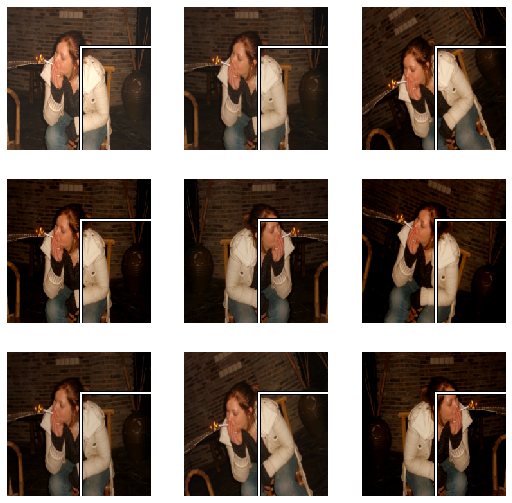

In [0]:
idx=3
fig,axes = plt.subplots(3,3, figsize=(9,9))
for i,ax in enumerate(axes.flat):
    x,y=next(iter(md.aug_dl))
    ima=md.val_ds.denorm(to_np(x))[idx]
    b = bb_hw(to_np(y[idx]))
    print(b)
    show_img(ima, ax=ax)
    draw_rect(ax, b)

![alt text](https://cdn-images-1.medium.com/max/1200/1*lAIQHKT0GbjY0fRZKmpFaA.png)

In [0]:
#A we can see the image gets rotated and lighting varies, but the bbox
# is not moving and is in the wrong spot.
#This is the problem with data augmentations when your dependent variable is 
#pixel values or in some way connected to the independent variable — they need 
#to be augmented together. As you can see in the bounding box coordinates 
#[ 115. 63. 240. 311.] , our image is 224 by 224 — so it is neither scaled nor cropped. 
#The dependent variable needs to go through all the geometric transformation as the independent variables.

#to do this every transformation has an optional tfm_y parameter
#TtfmType.COORD indicates that the y value represents a coordinate
#This needs to be added to all the augmentations including the tfms_from_model
augs = [RandomFlip(tfm_y=TfmType.COORD),
        RandomRotate(30, tfm_y=TfmType.COORD),
        RandomLighting(0.1,0.1, tfm_y=TfmType.COORD)]

tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=augs)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms, continuous=True, bs=4)

[ 66.  38. 105. 183.]
[ 59.  29. 122. 194.]
[ 49.  34. 114. 189.]
[ 46.  11. 156. 212.]
[ 42.  27. 132. 196.]
[ 33.  20. 137. 203.]
[ 65.  37. 107. 185.]
[ 49.  34. 115. 189.]
[ 28.  15. 146. 208.]


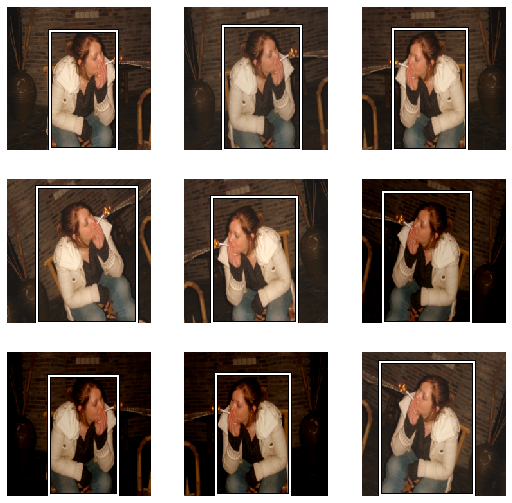

In [0]:
idx=3
fig,axes = plt.subplots(3,3, figsize=(9,9))
for i,ax in enumerate(axes.flat):
    x,y=next(iter(md.aug_dl))
    ima=md.val_ds.denorm(to_np(x))[idx]
    b = bb_hw(to_np(y[idx]))
    print(b)
    show_img(ima, ax=ax)
    draw_rect(ax, b)

![alt text](https://cdn-images-1.medium.com/max/1200/1*4V4sjFZxn-y2cU9tCJPEUw.png)

In [0]:
#Now the bbox's move with the image and are in the correct spot
#You may notice that sometimes it looks odd
#This is the constraint of the information we have. If the object occupied the 
#corners of the original bounding box, your new bounding box needs to be bigger 
#after the image rotates. So you must be careful of not doing too higher rotations 
#with bounding boxes because there is not enough information for them to stay 
#accurate. If we were doing polygons or segmentations, we would not have this problem.

tfm_y = TfmType.COORD
augs = [RandomFlip(tfm_y=tfm_y),
        RandomRotate(3, p=0.5, tfm_y=tfm_y),
        RandomLighting(0.05,0.05, tfm_y=tfm_y)]

#we have 3 degree of rotation to avoid the above problem and it also only rotates
# half of the time p=0.5

In [0]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms, continuous=True)

#tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=tfm_y, aug_tfms=augs)
#md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms, bs=bs, continuous=True)

In [0]:
x,y=next(iter(md.val_dl))
ima=md.val_ds.denorm(to_np(x))[0]
b = bb_hw(to_np(y[0])); b

array([ 49.,   0., 132., 206.])

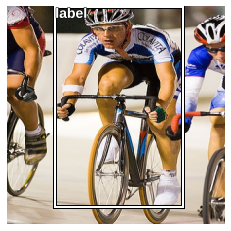

In [0]:
ax = show_img(ima)
draw_rect(ax, b)
draw_text(ax, b[:2], 'label')

In [0]:
#Lets create a convnet based on resnet 34
# fastai lets you add a custom_head to add to your own module on top of a convnet,
# instead of adaptive pooling and fully connected net which is added by default.
# In this case we dont want to do any pooling since we want to know the activations
#of each grid cell.
# The final layer has 4 activations one per bbox coordinate.
# We want to predict continuous not categorical so the MSE loss function
# used does not add any softmax or sigmoid to the module outputs.
512*7*7

25088

In [0]:
head_reg4 = nn.Sequential(Flatten(), nn.Linear(25088,4))
# Flatten() : Normally the previous layer has 7x7x512 in Resnet34, so flatten that out into a vector of length 25088
learn = ConvLearner.pretrained(f_model, md, custom_head=head_reg4)
learn.opt_fn = optim.Adam
learn.crit = nn.L1Loss()
# Rather than adding up squared errors, add up the absolute values of the errors.
# It is normally what you want because adding up the squared errors really penalizes bad misses by too much.

In [0]:
#learn.summary() will run a small batch of data through a model and prints out the size of tensors at every layer.
# As you can see, right before the Flatten layer, the tensor has the shape of 512 by 7 by 7.
#So if it were a rank 1 tensor (i.e. a single vector) its length will be 25088 (512 * 7 * 7)
#Thats why our customer heads input size is 25088 (see above)
# Output size is four since it is the bounding box coordinates
learn.summary()

![alt text](https://cdn-images-1.medium.com/max/1200/1*o9NFGVz1ua60kOpIafe5Hg.png)

 78%|███████▊  | 25/32 [00:18<00:05,  1.32it/s, loss=455]

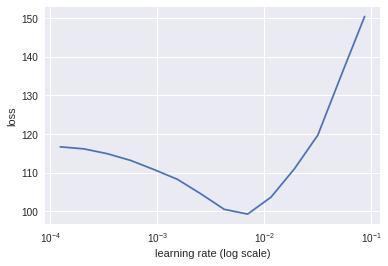

In [0]:

learn.lr_find(1e-5,100)
learn.sched.plot(5)

In [0]:
lr = 2e-3
learn.fit(lr, 2, cycle_len=2, cycle_mult=2)

epoch      trn_loss   val_loss   
    0      58.376073  34.099547 
    1      40.770374  30.903642 
    2      33.969024  27.529832 
    3      29.137565  26.720639 
    4      25.959812  26.289232 
    5      23.942676  26.224578 


[array([26.22458])]

epoch      trn_loss   val_loss   
    0      82.615445  27695589667897.344


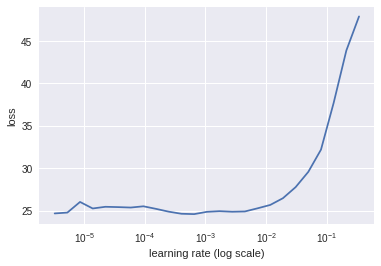

In [0]:
lrs = np.array([lr/100,lr/10,lr])
learn.freeze_to(-2)
lrf=learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [0]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)


epoch      trn_loss   val_loss   
    0      24.795348  23.660487 
    1      21.169556  23.336305 
    2      17.319524  21.159301 


[array([21.1593])]

In [0]:
learn.freeze_to(-3)
learn.fit(lrs, 1, cycle_len=2)

epoch      trn_loss   val_loss   
    0      15.846002  22.10733  
    1      14.798294  20.959187 


[array([20.95919])]

In [0]:
learn.save('reg4')
learn.load('reg4')

In [0]:
#Take a look at the results
x,y = next(iter(md.val_dl))
learn.model.eval()
preds = to_np(learn.model(VV(x)))

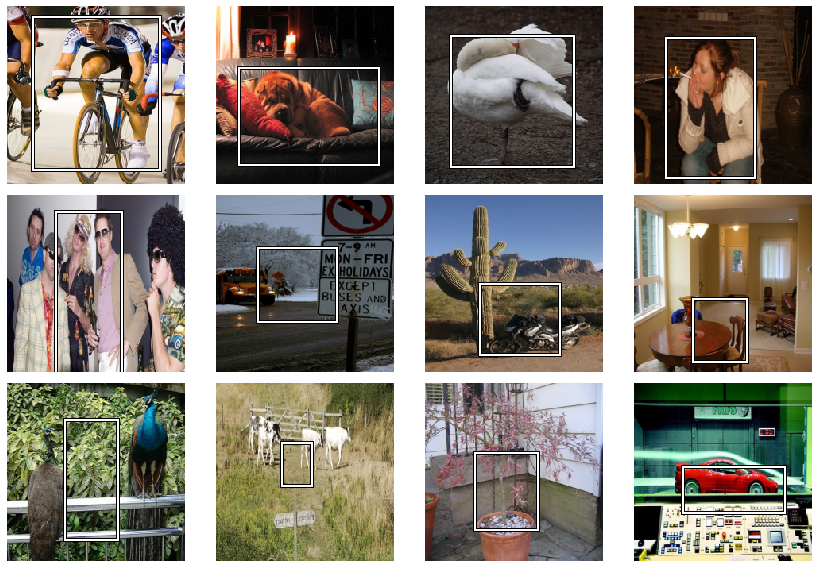

In [0]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(to_np(x))[i]
    b = bb_hw(preds[i])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
plt.tight_layout()

In [0]:
# ~~ Single Object Detection ~~

#Let’s combine the two to create something that can classify and localize the largest object in each image.
#3 things to do to train a NN:
#Data
#Architecture
#Loss Function

#1. Providing Data
#We need a ModelData object whose independent variable is the images and 
#the dependent variable is a tuple of bbox coordinates and class label.

#One way to do this is to create two ModelData objects representing the two
#dependent variables we want (one with bbox coordinates and other with classes)

f_model = resnet34
sz=224
bs=64

In [0]:
val_idxs = get_cv_idxs(len(trn_fns))

In [0]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=augs)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms,
   bs=bs, continuous=True, val_idxs=val_idxs)

In [0]:
md2 = ImageClassifierData.from_csv(PATH, JPEGS, CSV, tfms=tfms_from_model(f_model, sz))
#a dataset can be anything with __len__ and __getitem__. Here's a dataset
#that adds a 2nd label to an existing dataset:

In [0]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2): self.ds,self.y2 = ds,y2
    def __len__(self): return len(self.ds)
# ds: contains both independent and dependent variables
# y2: contains the additional dependent variables
# (x, (y,self.y2[i])): __getitem__ returns an independent variable and the combination
#of the two dependent variables
#We’ll use it to add the classes to the bounding boxes labels.
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))

In [0]:
#We’ll use it to add the classes to the bounding boxes labels.

trn_ds2 = ConcatLblDataset(md.trn_ds, md2.trn_y)
val_ds2 = ConcatLblDataset(md.val_ds, md2.val_y)

In [0]:
val_ds2[0][1]
#Here is an example dependent variable

(array([  0.,  49., 205., 180.], dtype=float32), 14)

In [0]:
#We can replace the dataloaders' datasets with these new ones.
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

In [0]:
#We have to denormalize the images from the dataloader before they can be plotted.
x,y=next(iter(md.val_dl))
idx=3
ima=md.val_ds.ds.denorm(to_np(x))[idx]
b = bb_hw(to_np(y[0][idx])); b

array([ 52.,  38., 107., 185.])

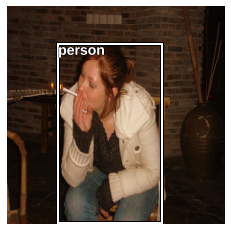

In [0]:
ax = show_img(ima)
draw_rect(ax, b)
draw_text(ax, b[:2], md2.classes[y[1][idx]])

In [0]:
# ~~ Choosing Architectures ~~

#The architecture will be the same as the one we used for the classifier and bounding box regression, but we will just combine them. 
#If we have c classes then the number of activations we need in the final layer is
#4 plus c. 4 bbox coordinates and c probabilities (one per class).
#we'll use an extra linear layer this time, plus some dropout, to help us train a more
#flexible model. 

#In general, we want our custom head to be capable of solving the problem on 
#its own if the pre-trained backbone it is connected to is appropriate.

#If you were wondering why there is no BatchNorm1d after the first ReLU , 
#ResNet backbone already has BatchNorm1d as its final layer.

In [0]:
head_reg4 = nn.Sequential(
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(25088,256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256,4+len(cats)),
)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)

learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam

In [0]:
# ~~ Loss Function ~~

#the loss function needs to look at these 4 + len(cats) activations and decide if they
#are good-whether these numbers accurately reflect the position and class of largest
#object in the image.
#For the first 4 activations, we will use the L1Loss just like we did before(L1Loss,
#is the mean squared error as opposed to the sum of squared erros, it uses sum of
#absolute values). For the rest of the activations we can use the crossentropy loss.

def detn_loss(input, target):
  bb_t,c_t = target ##bb target class target
  bb_i,c_i = input[:, :4], input[:, 4:] #bb and class input
  bb_i = F.sigmoid(bb_i)*224 
  # I looked at these quantities separately first then picked a multiplier
  #   to make them approximately equal
  return F.l1_loss(bb_i, bb_t) + F.cross_entropy(c_i, c_t)*20

def detn_l1(input, target):
    bb_t,_ = target
    bb_i = input[:, :4]
    bb_i = F.sigmoid(bb_i)*224
    return F.l1_loss(V(bb_i),V(bb_t)).data

def detn_acc(input, target):
    _,c_t = target
    c_i = input[:, 4:]
    return accuracy(c_i, c_t)

learn.crit = detn_loss
learn.metrics = [detn_acc, detn_l1]

#input : activations
#target: ground truth
#bb_t, c_t = target : Our custom dataset returns a tuple containing bounding box
#classes. This assignment will destructure them.
#bb_i,c_i = input[:, :4], input[:, :4] : the first : is for the batch dimension
# b_i = F.sigmoid(bb_i)*224 : we know our image is 224 by 224. Sigmoid will 
#force it to be between 0 and 1, and multiply by 224 to help our nn be in the range of what is has to be.

#Now we have our inputs we can compute the L1 loss and add the cross entropy
#F.l1_loss(bb_i, bb_t) + F.cross_entropy(c_i, c_t)*20
#This is out loss function. Cross entropy and L1Loss may be wildly different scales
#in which case the larger one will dominate. 
#If we multiply the cross entropy by 20 it seems to give a similar scale
#we then grab l1 loss and added it to the metrics

Question: As a general rule, is it better to put BatchNorm before or after ReLU [18:02]? Jeremy would suggest to put it after a ReLU because BathNorm is meant to move towards zero-mean one-standard deviation. So if you put ReLU right after it, you are truncating it at zero so there is no way to create negative numbers. But if you put ReLU then BatchNorm, it does have that ability and gives slightly better results. Having said that, it is not too big of a deal either way. You see during this part of the course, most of the time, Jeremy does ReLU then BatchNorm but sometimes does the opposite when he wants to be consistent with the paper.

Question: What is the intuition behind using dropout after a BatchNorm? Doesn’t BatchNorm already do a good job of regularizing [19:12]? BatchNorm does an okay job of regularizing but if you think back to part 1 when we discussed a list of things we do to avoid overfitting and adding BatchNorm is one of them as is data augmentation. But it’s perfectly possible that you’ll still be overfitting. One nice thing about dropout is that is it has a parameter to say how much to drop out. Parameters are great specifically parameters that decide how much to regularize because it lets you build a nice big over parameterized model and then decide on how much to regularize it. Jeremy tends to always put in a drop out starting with p=0 and then as he adds regularization, he can just change the dropout parameter without worrying about if he saved a model he want to be able to load it back, but if he had dropout layers in one but no in another, it will not load anymore. So this way, it stays consistent.

 94%|█████████▍| 30/32 [00:27<00:00,  2.20it/s, loss=463]

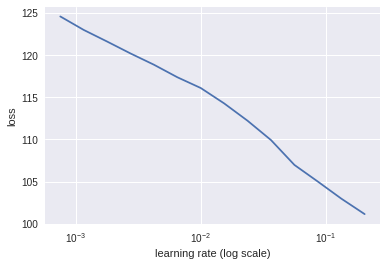

In [0]:
learn.lr_find()
learn.sched.plot()

In [0]:
lr=1e-2
learn.fit(lr, 1, cycle_len=3, use_clr=(32,5))

epoch      trn_loss   val_loss   detn_acc   detn_l1    
    0      74.172695  45.506181  0.78       32.629254 
    1      52.698632  36.740389  0.812      25.180171 
    2      43.286724  34.916933  0.822      24.360233 


[array([34.91693]), 0.8220000009536743, 24.360232879638673]

In [0]:
learn.save('reg1_0')

In [0]:
learn.freeze_to(-2)

 91%|█████████ | 29/32 [00:29<00:01,  1.68it/s, loss=245]

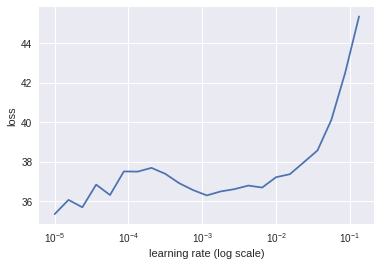

In [0]:
lrs = np.array([lr/100, lr/10, lr])

learn.lr_find(lrs/1000)
learn.sched.plot(0)

In [0]:
learn.fit(lrs/5, 1, cycle_len=5, use_clr=(32,10))
#a detection accuracy is in the low 80s which is the same as what it was before.
#This isnt surprising since resnet was designed to do classification. It 
#wasnt designed to do bbox regression.
#It was explicitly actually designed in such a way to not care about geometry 
#— it takes the last 7 by 7 grid of activations and averages them all together 
#throwing away all the information about where everything came from.

#when we do accuracy(classification) and bbox at the same time, the L1 seems a 
#little bit better than when we do bbox regression.

#~~this is the idea to get your head around~~
#The idea is this — figuring out what the main object in an image is, is kind of the hard part. 
#Then figuring out exactly where the bounding box is and what class it is is the easy part in a way. 
#So when you have a single network that’s both saying what is the object and where is the object, 
#it’s going to share all the computation about finding the object. And all that shared 
#computation is very efficient. When we back propagate the errors in the class and in the place, 
#that’s all the information that is going to help the computation around finding the biggest object. 
#So anytime you have multiple tasks which share some concept of what those tasks would need to do to 
#complete their work, it is very likely they should share at least some layers of the network together. 
#Later today, we will look at a model where most of the layers are shared except for the last one.

epoch      trn_loss   val_loss   detn_acc   detn_l1    
    0      38.073829  35.951119  0.79       22.656508 
    1      32.130939  33.353031  0.834      21.600607 
    2      27.217202  31.494627  0.816      20.470902 
    3      24.166181  30.809762  0.838      19.514336 
    4      21.718367  30.626879  0.834      19.494581 


[array([30.62688]), 0.8339999995231628, 19.49458073425293]

In [0]:
learn.save('reg1_1')
learn.load('reg1_1')


In [0]:
learn.unfreeze()

In [0]:
learn.fit(lrs/10, 1, cycle_len=10, use_clr=(32,10))


epoch      trn_loss   val_loss   detn_acc   detn_l1    
    0      12.414459  30.761206  0.83       18.733348 
    1      13.333257  32.493862  0.816      19.107011 
    2      13.423133  30.183844  0.83       18.17179  
    3      13.221679  32.917954  0.82       18.257188 
    4      12.853535  32.433034  0.828      18.293449 
    5      12.442952  31.229769  0.818      18.170336 
    6      12.153467  31.000891  0.824      17.96626  
    7      11.625495  30.577745  0.822      17.761595 
    8      11.419675  30.320265  0.83       17.720622 
    9      11.077304  30.548175  0.824      17.716202 


[array([30.54817]), 0.8239999980926513, 17.716201866149902]

In [0]:
learn.save('reg1')
learn.load('reg1')


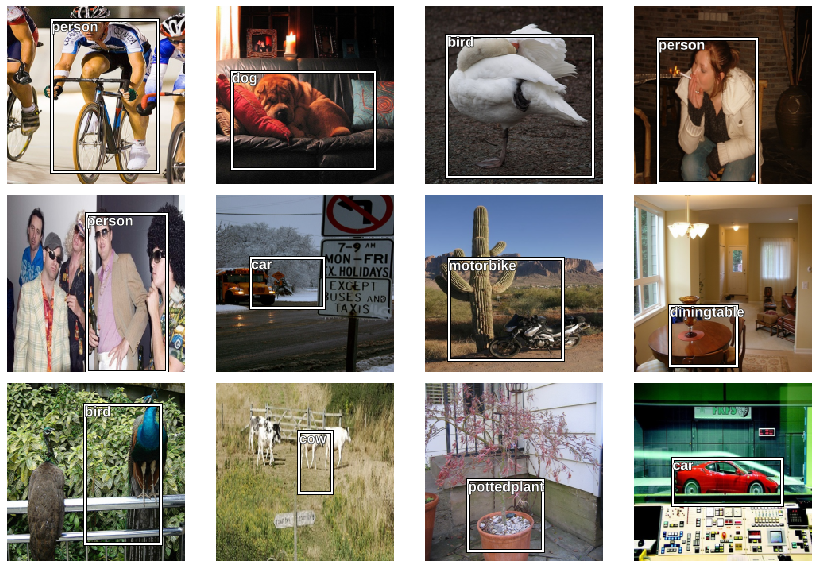

In [0]:
y = learn.predict()
x,_ = next(iter(md.val_dl))
from scipy.special import expit
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.ds.denorm(to_np(x))[i]
    bb = expit(y[i][:4])*224
    b = bb_hw(bb)
    c = np.argmax(y[i][4:])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
    draw_text(ax, b[:2], md2.classes[c])
plt.tight_layout()

#Here are the results, It does a good job when there is a single major object

In [0]:
#